## Chapter 8. Regression Trees and Rule-Based Models

In [55]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
os.path.isdir(APMdatafolder)

True

In [3]:
data_filename='solubility.RData'
file_path = os.path.join(APMdatafolder, data_filename)
datadict = pyreadr.read_r(file_path)

solTestX, solTestXtrans, solTestY, solTrainX, solTrainXtrans, solTrainY \
= datadict['solTestX'], datadict['solTestXtrans'], datadict['solTestY'], datadict['solTrainX'], datadict['solTrainXtrans'], datadict['solTrainY']

In [4]:
data_filename = 'concrete.RData'
file_path = os.path.join(APMdatafolder, data_filename)
datadict = pyreadr.read_r(file_path)

concretedata = datadict['concrete']

In [5]:
# training (transformed)
trainX, trainY= solTrainXtrans, solTrainY

# test (transformed)
testX, testY = solTestXtrans, solTestY

### Tree splitting

In [6]:
# calculate the SSE for the continuum of splits
def find_splits(values):
    '''Find all splits points for a set of values.'''
    uni_values = np.unique(values)
    split_points = []
    for i in range(len(uni_values)-1):
        # insert split points in the middle of two unique values
        split_points.append((uni_values[i] + uni_values[i+1])/2.0)
    return split_points
    
def sse_split(X, y, split_point):
    '''Calculate SSE for a given split point.'''
    s1 = np.where(X <= split_point)[0]
    s2 = np.where(X > split_point)[0]
    sse = 0
    
    try:
        y1 = np.mean(y[s1])
        y2 = np.mean(y[s2])
        sse+=sum((y[s1]-y1)**2)
        sse+=sum((y[s2]-y2)**2)
    except:
        # if y is a pd.dataframe
        y1 = np.mean(y.values[s1])
        y2 = np.mean(y.values[s2])
        sse+=sum((y.values[s1,0]-y1)**2)
        sse+=sum((y.values[s2,0]-y2)**2)
        
    return sse

In [7]:
# calculate SSE for continuum of splits for 'NumCarbon'
split_points = find_splits(trainX['NumCarbon'])
sse = []
for i in split_points:
    sse.append(sse_split(trainX['NumCarbon'], trainY, i))

Text(0, 0.5, 'SSE')

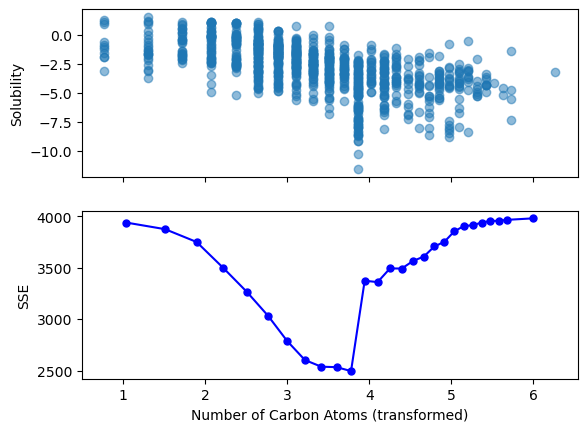

In [11]:
# plot the SSE for the continuum of splits
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# number of carbon atoms
ax1.scatter(trainX['NumCarbon'], trainY, alpha = 0.5)
ax1.set_ylabel('Solubility')

# SSEs
ax2.plot(split_points, sse, 'bo-',ms = 5)
ax2.set_xlabel('Number of Carbon Atoms (transformed)')
ax2.set_ylabel('SSE')

([<matplotlib.axis.XTick at 0x7ff6626243d0>,
 [Text(1, 0, '<= 3.7768'), Text(2, 0, '> 3.7768')])

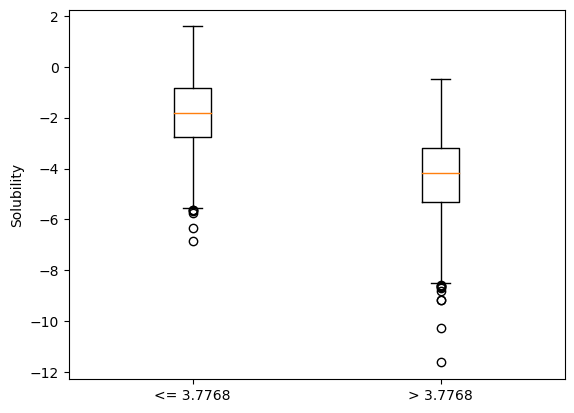

In [15]:
split_pt = split_points[np.argmin(sse)]

s1 = np.where(trainX['NumCarbon'] <= split_pt)[0]
s2 = np.where(trainX['NumCarbon'] > split_pt)[0]
y = [trainY.values[s1, 0], trainY.values[s2, 0]]

plt.boxplot(y)
plt.ylabel('Solubility')
plt.xticks([1, 2], ['<= '+str(round(split_pt,4)), '> '+str(round(split_pt,4))])    

### 1. Single Trees

In [121]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=3)

treg = DecisionTreeRegressor()
gs_param = {
    'min_samples_split': range(2, 100),
}
gs_treg = GridSearchCV(treg, gs_param, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_treg.fit(trainX, trainY.values[:, 0])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': range(2, 100)},
             scoring='neg_root_mean_squared_error')

Text(0, 0.5, 'RMSE (Cross-Validation)')

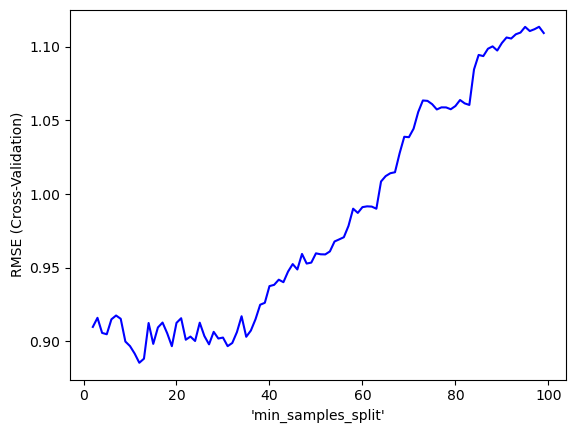

In [122]:
gs_grid_rmse = -gs_treg.cv_results_['mean_test_score']

plt.plot(range(2,100), gs_grid_rmse, c = 'b')
plt.xlabel("'min_samples_split'")
plt.ylabel('RMSE (Cross-Validation)')

In [123]:
gs_treg_rmse= np.column_stack((
    np.array(gs_treg.cv_results_['param_min_samples_split']), \
                               -np.array(gs_treg.cv_results_['mean_test_score']),\
                               np.array(gs_treg.cv_results_['std_test_score'])
))

In [125]:
# use the one-standard-error rule
thres_rmse = np.min(gs_treg_rmse[:,1]) + gs_treg_rmse[np.argmin(gs_treg_rmse[:,1]), 2]

for idx, i in reversed(list(enumerate(gs_treg_rmse))):
    if i[1] < thres_rmse:
        best_param = i[0]
        break
        
print(f"The best parameter: 'min_samples_split' = {best_param}.")

The best parameter: 'min_samples_split' = 56.


### 2. Bagged Trees

In [12]:
sol_trainX, sol_trainY = np.array(solTrainXtrans), np.array(solTrainY)
sol_testX, sol_testY = np.array(solTestXtrans), np.array(solTestY)

In [13]:
conX, conY = np.array(concretedata.drop(columns = ['CompressiveStrength'])), np.array(concretedata['CompressiveStrength'])

In [14]:
from sklearn.model_selection import train_test_split
con_trainX, con_testX, con_trainY, con_testY = train_test_split(conX, conY, test_size =0.2)

In [15]:
def boostrap_sample(X, Y):
    '''Generate a boostrap sample of the original data.'''
    bsample = np.random.choice(range(len(Y)), len(Y), replace=True)
    bs_X = X[bsample]
    bs_Y = Y[bsample]
    return bs_X, bs_Y

def test_pred(trainX, trainY, testX, model):
    '''Generate a test set prediction based on the given model.'''
    reg = model
    reg.fit(trainX, trainY)
    return reg.predict(testX)

def test_rmse(Y, pred_Y):
    '''Calculate RMSE based on the test set prediction.'''
    y = np.ravel(Y)
    pred_y = np.ravel(pred_Y)
    return np.sqrt(np.mean((y - pred_y)**2))

In [16]:
# bagging: tree vs linear regression vs MARS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
np.int =int
np.float = float
from pyearth import Earth

np.random.seed(100)

tree_solu_rmse = []
lm_solu_rmse = []
mars_solu_rmse = []

for i in range(0, 50, 2):
    # generate a boostrap sample
    bs_sol_trainX, bs_sol_trainY = boostrap_sample(sol_trainX, sol_trainY)
    # train a model
    tree_solu = test_pred(bs_sol_trainX, bs_sol_trainY, sol_testX, DecisionTreeRegressor())
    lm_solu = test_pred(bs_sol_trainX, bs_sol_trainY, sol_testX, LinearRegression())
    mars_solu = test_pred(bs_sol_trainX, bs_sol_trainY, sol_testX, Earth())
    # aggregate prediction
    if i != 0:
        tree_solu_agg = np.vstack([tree_solu_agg, tree_solu])
        lm_solu_agg = np.vstack([lm_solu_agg, lm_solu])
        mars_solu_agg = np.vstack([mars_solu_agg, mars_solu])
    else: # if agg not defined
        tree_solu_agg = tree_solu
        lm_solu_agg = lm_solu
        mars_solu_agg = mars_solu
    
    # calculate rmse
    tree_solu_rmse.append(test_rmse(sol_testY, np.mean(tree_solu_agg, 0)))
    lm_solu_rmse.append(test_rmse(sol_testY, np.mean(lm_solu_agg, 0)))
    mars_solu_rmse.append(test_rmse(sol_testY, np.mean(mars_solu_agg, 0)))

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn_contrib_py_earth-0.1.0+0.gb209d19.dirty-py3.10-macosx-10.9-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn_contrib_py_earth-0.1.0+0.gb209d19.dirty-py3.10-macosx-10.9-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/chenxu/miniconda3/lib/python3.10/site-p

Text(0.06, 0.5, 'RMSE')

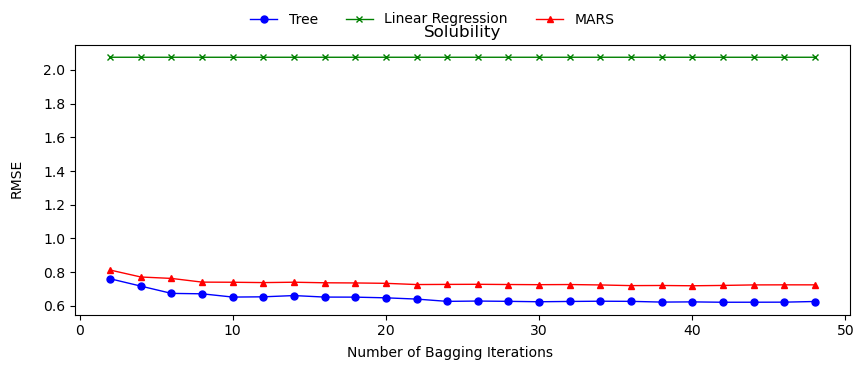

In [17]:
# solubility data
fig, ax1 = plt.subplots(figsize = (10,3.5))
l1, l2, l3 = ax1.plot(range(0, 50, 2)[1:], tree_solu_rmse[1:], 'b-o', 
                      range(0, 50, 2)[1:], lm_solu_rmse[1:], 'g-x',
                      range(0, 50, 2)[1:], mars_solu_rmse[1:], 'r-^',lw = 1,ms = 5)
ax1.set_title('Solubility')

fig.legend((l1, l2, l3), ('Tree', 'Linear Regression', 'MARS'), loc='upper center', ncol=3, frameon=False)
fig.text(0.5, 0.0, 'Number of Bagging Iterations', ha='center', va='center')
fig.text(0.06, 0.5, 'RMSE', va='center', rotation='vertical')

In [20]:
np.random.seed(3)

tree_concre_rmse = []
lm_concre_rmse = []
mars_concre_rmse = []

for i in range(0, 50, 2):
    # generate a boostrap sample
    bs_con_trainX, bs_con_trainY = boostrap_sample(con_trainX, con_trainY)
    # train a model
    tree_concre = test_pred(bs_con_trainX, bs_con_trainY, con_testX, DecisionTreeRegressor())
    lm_concre = test_pred(bs_con_trainX, bs_con_trainY, con_testX, LinearRegression())
    mars_concre = test_pred(bs_con_trainX, bs_con_trainY, con_testX, Earth())
    # aggregate prediction
    if i != 0:
        tree_concre_agg = np.vstack([tree_concre_agg, tree_concre])
        lm_concre_agg = np.vstack([lm_concre_agg, lm_concre])
        mars_concre_agg = np.vstack([mars_concre_agg, mars_concre])
    else: # if agg not defined
        tree_concre_agg = tree_concre
        lm_concre_agg = lm_concre
        mars_concre_agg = mars_concre
    
    # calculate rmse
    tree_concre_rmse.append(test_rmse(con_testY, np.mean(tree_concre_agg, 0)))
    lm_concre_rmse.append(test_rmse(con_testY, np.mean(lm_concre_agg, 0)))
    mars_concre_rmse.append(test_rmse(con_testY, np.mean(mars_concre_agg, 0)))

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn_contrib_py_earth-0.1.0+0.gb209d19.dirty-py3.10-macosx-10.9-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn_contrib_py_earth-0.1.0+0.gb209d19.dirty-py3.10-macosx-10.9-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/chenxu/miniconda3/lib/python3.10/site-p

Text(0.06, 0.5, 'RMSE')

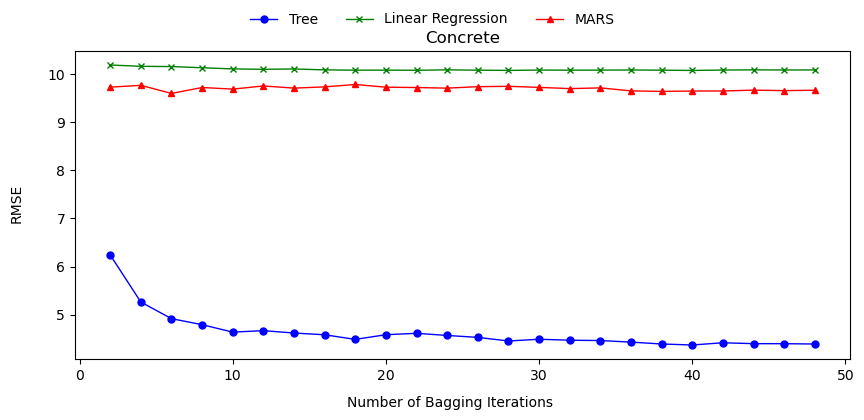

In [21]:
fig, ax2 = plt.subplots(figsize = (10,4))

# concrete date 
ax2.plot(range(0, 50, 2)[1:], tree_concre_rmse[1:], 'b-o',
         range(0, 50, 2)[1:], lm_concre_rmse[1:], 'g-x',
         range(0, 50, 2)[1:], mars_concre_rmse[1:], 'r-^', lw = 1, ms = 5)
ax2.set_title('Concrete')

fig.legend((l1, l2, l3), ('Tree', 'Linear Regression', 'MARS'), loc='upper center', ncol=3, frameon=False)
fig.text(0.5, 0., 'Number of Bagging Iterations', ha='center', va='center')
fig.text(0.06, 0.5, 'RMSE', va='center', rotation='vertical')

### 3. Random forest

In [35]:
sol_trainX, sol_trainY = np.array(solTrainXtrans), np.array(solTrainY).ravel()
sol_testX, sol_testY = np.array(solTestXtrans), np.array(solTestY).ravel()

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=3)

In [41]:
cv_rmse = []
oob_rmse = []
for m_try in range(10, 228, 22):
    print(f"Value of max_features is {m_try}, RandomForest...",end = "")
    # out-of-bag score
    rf = RandomForestRegressor(n_estimators=1000, max_features=m_try, oob_score=True)
    rf.fit(sol_trainX, sol_trainY)
    oob_rmse.append(np.sqrt(mean_squared_error(sol_trainY, rf.oob_prediction_)))
    
    print(f"done. Cross Validation: ", end = "")
    # cross-validation score
    cv_temp_rmse = []
    for i, (train_indices, test_indices) in enumerate(cv.split(sol_trainX)):
        print(f"{i} ",end = "")
        trainX = sol_trainX[train_indices]
        trainY = sol_trainY[train_indices]
        testX = sol_trainX[test_indices]
        testY = sol_trainY[test_indices]
        
        rf = RandomForestRegressor(n_estimators=1000, max_features=m_try)
        rf.fit(trainX, trainY)
        cv_temp_rmse.append(np.sqrt(mean_squared_error(testY, rf.predict(testX))))
    cv_rmse.append(cv_temp_rmse)
    print("done.")   

Value of max_features is 10, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 32, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 54, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 76, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 98, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 120, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 142, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 164, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 186, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.
Value of max_features is 208, RandomForest...done. Cross Validation: 0 1 2 3 4 5 6 7 8 9 done.


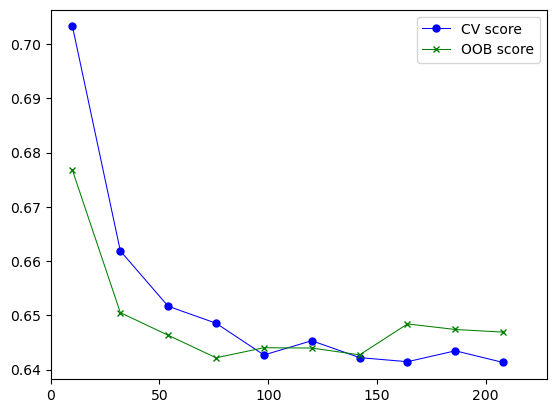

In [50]:
plt.plot(range(10, 228, 22), np.mean(cv_rmse, 1), 'bo-', ms = 5,lw = 0.75, label = 'CV score')
plt.plot(range(10, 228, 22), oob_rmse, 'gx-',lw = 0.75, ms = 5,label = 'OOB score')
plt.legend()
plt.xlim(0, 228)
plt.show()

In [53]:
def viz_importance(scores, num_predictors = 16, predictor_names = solTrainXtrans.columns):
    '''Visualize the relative importance of predictors.'''
    idx = np.argsort(scores)[-num_predictors:]
    names = predictor_names[idx]
    importances = scores[idx]
    
    y_pos = np.arange(num_predictors)
    plt.barh(y_pos, importances, align='center', alpha=0.4)
    plt.yticks(y_pos, names)
    plt.xlabel('Importance')

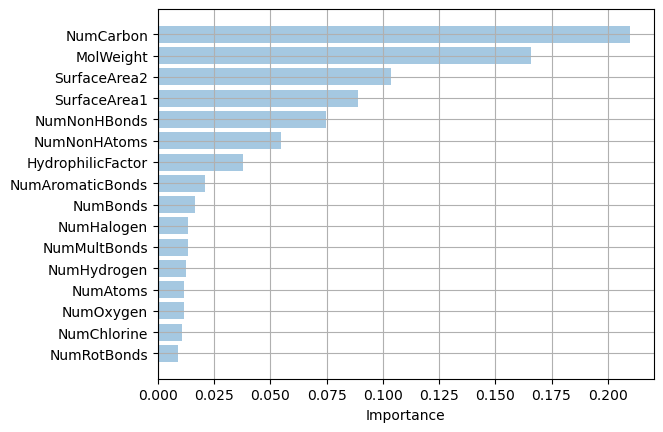

In [56]:
rf = RandomForestRegressor(n_estimators=1000, max_features=120)
rf.fit(sol_trainX, sol_trainY)
viz_importance(rf.feature_importances_)

### 4. Boosting

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=3)

gs_param = {
    'learning_rate': [0.01, 0.1],
    'max_depth': range(1, 8, 2),
    'n_estimators': range(100, 1001, 50),
    'subsample': [0.5],
}
gbr = GradientBoostingRegressor()
gs_gbr = GridSearchCV(gbr, gs_param, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_gbr.fit(sol_trainX, sol_trainY)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': range(1, 8, 2),
                         'n_estimators': range(100, 1001, 50),
                         'subsample': [0.5]},
             scoring='neg_root_mean_squared_error')

In [70]:
cv_results = pd.DataFrame(gs_gbr.cv_results_)

In [71]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_subsample', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [88]:
scores1 = cv_results[cv_results['param_learning_rate']==0.01][['param_max_depth','param_n_estimators', 'mean_test_score']]
scores1['mean_test_score'] = - scores1['mean_test_score']
scores2 = cv_results[cv_results['param_learning_rate']==0.1][['param_max_depth','param_n_estimators', 'mean_test_score']]
scores2['mean_test_score'] = - scores2['mean_test_score']

Text(0.5, 1.0, 'learning rate: 0.10')

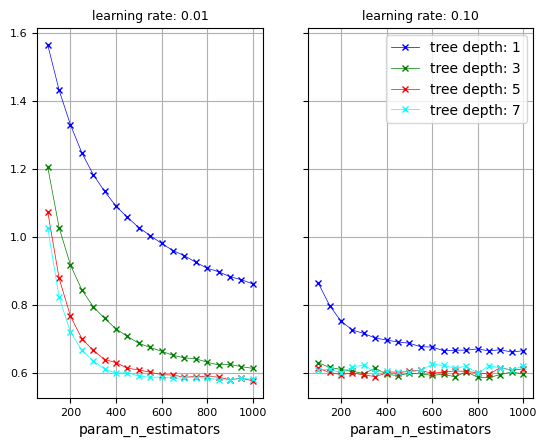

In [117]:
colorlist = ['blue','green','red','cyan']
f, (ax1,ax2) = plt.subplots(ncols =2 ,sharey = True)
for i in range(1,8,2):
    scores1[scores1['param_max_depth']==i][['param_n_estimators', 'mean_test_score']].plot(x='param_n_estimators',
                                                                                           y = 'mean_test_score',
                                                                                           style = 'x-',
                                                                                           color=colorlist[i//2],
                                                                                           legend=False,
                                                                                           ms = 5, lw = 0.5, fontsize = 8,
                                                                                           ax = ax1)
    scores2[scores2['param_max_depth']==i][['param_n_estimators', 'mean_test_score']].plot(x='param_n_estimators',
                                                                                           y = 'mean_test_score',
                                                                                           style = 'x-',
                                                                                           color=colorlist[i//2],
                                                                                           label = 'tree depth: '+str(i),
                                                                                           ms = 5, lw = 0.5, fontsize = 8,
                                                                                           ax = ax2)
ax1.set_title('learning rate: 0.01',fontsize = 9)
ax2.set_title('learning rate: 0.10',fontsize = 9)

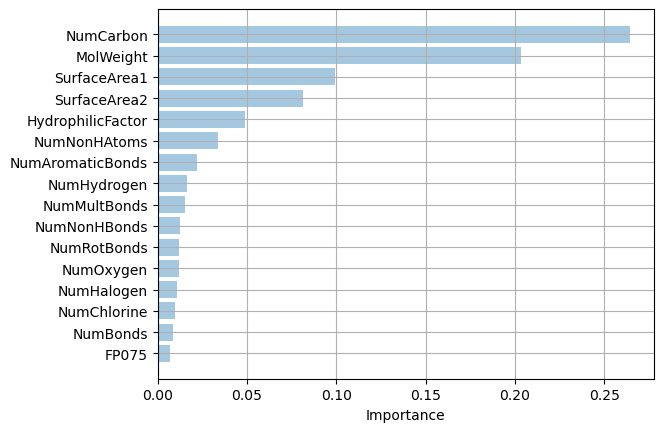

In [118]:
gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5)
gbr.fit(sol_trainX, sol_trainY)
viz_importance(gbr.feature_importances_)